# Natural Language Processing (NLP) and Neural Networks with NLTK and the Tensorflow Keras API

### Introduction

In this notebook, I will be building a model to predict whether or not a tweet is about a real disaster, using the data given for the assignment. The data has been provided in separate training and test sets, so only the training set will be used in the model training/validation while the test set will be saved for the end to evalute the model.

First the data will be loaded and explored, then the data will be cleaned and preprocessed, and finally the model will be built and trained. I decided to add some features to the data set (e.g. number of words in a tweet) to see if they would improve the model's performance. I also used the prebuild sentiment analysis model from the NLTK library to see if it would improve the model's performance. Finally I used the sklearn library to vectorize the text data with the TF-IDF vectorizer and the nltk tweet tokenizer to tokenize the text data. After all of this, I used the tensorflow.keras library to build and train the model.

### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import TweetTokenizer
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve
import random

In [2]:
random.seed(42)

In [3]:
nltk.download('stopwords')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chief\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\chief\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [4]:
stop_words = set(stopwords.words('english'))

### Custom Functions

1. *dtype_convert*: converts the data type of a column in a dataframe
2. *link_count*: if a link exists in a tweet
2. *get_polarity*: returns the polarity of a tweet using the NLTK sentiment analysis model
2. *return_xy*: returns the x and y data from a dataframe
2. *return_vectorized_data*: returns the vectorized text and extra features from a dataframe
2. *plot_history*: plots the training and validation accuracy and loss from a history object
2. *plot_roc*: plots the ROC curve using the best saved model and the test data

In [5]:
def dtype_convert(data : pd.DataFrame):
    """Converts the data types of the numeric columns in a dataframe to the smallest possible type.
    
    Parameters
    ----------
    data : pd.DataFrame to have its numeric columns converted.
    """

    int_list = ['int8', 'int16', 'int32', 'int64']
    float_list = ['float16', 'float32', 'float64']

    for col in data.select_dtypes(include=np.number).columns:

        data_type = data[col].dtype
        
        # Convert to int
        if data_type in int_list:

            n_range = [abs(data[col].max()), abs(data[col].min())]
            n_max = max(n_range)

            if n_max <= 127:
                data[col] = data[col].astype(np.int8)

            elif n_max <= 32767:
                data[col] = data[col].astype(np.int16)

            elif n_max <= 2147483647:
                data[col] = data[col].astype(np.int32)

            else:
                data[col] = data[col].astype(np.int64)

        # Convert to float
        elif data_type in float_list:
                
                n_range = [abs(data[col].max()), abs(data[col].min())]
                n_max = max(n_range)
    
                if n_max <= 3.4e+38:
                    data[col] = data[col].astype(np.float32)
    
                else:
                    data[col] = data[col].astype(np.float64)
    
    return data
        

In [6]:
def link_count(text : str):
    """Returns binary value indicating whether a tweet contains a link or not.
    
    Parameters
    ----------
    text : str to be checked for links."""

    # Checks string for http
    links = text.count('http')

    if links > 0:
        return 1
    
    else:
        return 0

In [7]:
def get_polarity(row : pd.Series):
    """Returns the polarity of a tweet using the VADER sentiment analyzer from NLTK.
    
    Parameters
    ----------
    row : pd.Series (to be applied on rows of pd.DataFrame) containing the text of a tweet."""

    sia = SentimentIntensityAnalyzer()

    text = row['text']
    polarity = sia.polarity_scores(text)

    neg = polarity['neg']
    neu = polarity['neu']
    pos = polarity['pos']
    compound = polarity['compound']

    return neg, neu, pos, compound

In [8]:
def return_xy(data):

    # Add new features including polarity scores
    # Binary feature for whether a tweet contains a link
    data['links_f'] = data['text'].apply(link_count).astype(np.int8)
    
    data['tweet_len'] = data['text'].str.len()
    data['word_count'] = data['text'].str.split().str.len()
    data['word_density'] = data['tweet_len'] / (data['word_count'])

    # Get polarity scores
    print('Getting polarity scores...')
    data['neg'], data['neu'], data['pos'], data['compound_f'] = zip(*data.apply(get_polarity, axis=1))

    # Convert dtypes to save memory
    #data['target'] = data['target'].astype('bool')
    data = dtype_convert(data)
    
    # Columns for X and y
    X = data.drop('target', axis=1)
    y = data['target'].astype('int8')

    return X, y

In [9]:
def return_vectorized_data(train : pd.DataFrame, test : pd.DataFrame, text : list, features : list,
                           max_features=None, stop_words=None):
    """Returns vectorized data for training and testing.

    Parameters
    ----------
    train : pd.DataFrame containing training data.
    test : pd.DataFrame containing testing data.
    text : str indicating the column name of the text data.
    features : list of str indicating the column names of the numeric features.
    max_features : int indicating the maximum number of features to be used in the vectorizer.
    stop_words : list of str indicating the stop words to be used in the vectorizer.
    """

    tk = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)

    vectorizer = TfidfVectorizer(tokenizer=tk.tokenize, strip_accents='unicode', max_features=max_features, stop_words=stop_words)

    v_train = vectorizer.fit_transform(train[text])
    v_test = vectorizer.transform(test[text])

    v_train = pd.DataFrame(v_train.toarray(), columns=vectorizer.get_feature_names_out(), index=train.index)
    v_test = pd.DataFrame(v_test.toarray(), columns=vectorizer.get_feature_names_out(), index=test.index)

    v_train = v_train[v_train.columns].astype(np.float32)
    v_test = v_test[v_test.columns].astype(np.float32)

    v_train = v_train.join(train[features], how='left', lsuffix='_v', rsuffix='_f')
    v_test = v_test.join(test[features], how='left', lsuffix='_v', rsuffix='_f')

    return v_train, v_test

In [10]:
def plot_history(history):
    """Plots the training and validation loss and accuracy for a model.

    Parameters
    ----------
    history : Keras history object.
    """

    fig, ax = plt.subplots(2, 1, figsize=(11, 11))

    auc_best = np.max(history.history['val_auc'])
    auc_best_epoch = np.argmax(history.history['val_auc'])
    auc_max = history.history['auc'][auc_best_epoch]


    ax[0].plot(history.history['auc'], label='Train')
    ax[0].plot(history.history['val_auc'], label='Validation')
    ax[0].vlines(auc_best_epoch, 0, np.max(history.history['val_auc']), color='purple', linestyles='dashed', label='Best Epoch')

    ax[0].annotate(f'{auc_best - np.max(history.history["auc"]):.4f}',
                    xy=(auc_best_epoch, auc_max),
                    xytext=(auc_best_epoch, auc_best-0.05),
                    arrowprops=dict(facecolor='black', shrink=0.05, width=0.7, headwidth=5))

    ax[0].set_ylabel('AUC')
    #ax[0].set_title('AUC vs. Epoch')
    ax[0].legend(loc='lower left')

    loss_best = np.min(history.history['val_loss'])
    loss_best_epoch = np.argmin(history.history['val_loss'])
    loss_max = history.history['loss'][loss_best_epoch]

    ax[1].plot(history.history['loss'], label='Train')
    ax[1].plot(history.history['val_loss'], label='Validation')
    ax[1].vlines(loss_best_epoch, 0, loss_best, color='purple', linestyles='dashed', label='Best Epoch')

    ax[1].annotate(f'{loss_best - np.min(history.history["loss"]):.4f}',
                    xy=(loss_best_epoch, loss_max),
                    xytext=(loss_best_epoch, loss_best+.01),
                    arrowprops=dict(facecolor='black', shrink=0, width=0.7, headwidth=5))

    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')
    #ax[1].set_title('Loss vs. Epoch')

    ax[1].legend(loc='lower left')

    plt.show()

In [11]:
def plot_roc(X_train, X_test, y_train, y_test, model):
    """Plots the ROC AUC curve for a model.

    Parameters
    ----------
    X_train : pd.DataFrame or numpy array containing the training data.
    X_test : pd.DataFrame or numpy array containing the testing data.
    y_train : pd.Series or numpy array containing the training target.
    y_test : pd.Series or numpy array containing the testing target.
    model : Keras model.
    """
    
    fpr_train, tpr_train, thresholds_train = roc_curve(y_train, model.predict(X_train))
    fpr_test, tpr_test, thresholds_test = roc_curve(y_test, model.predict(X_test))

    # Set figure size
    plt.figure(figsize=(10, 10))

    plt.plot(fpr_train, tpr_train, label='Train')
    plt.plot(fpr_test, tpr_test, label='Test')

    plt.legend(['Train', 'Test'], loc='upper left')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC AUC Curve')
    plt.show()

### Import Data

In [12]:
train_data = pd.read_csv('data/bonus_train_data-2.csv')
test_data = pd.read_csv('data/bonus_test_data-2.csv')

### Add Features

In [13]:
X_train, y_train = return_xy(train_data)
X_test, y_test = return_xy(test_data)

features = ['tweet_len', 'word_count', 'word_density', 'links_f', 'neg', 'neu', 'pos', 'compound_f']

Getting polarity scores...
Getting polarity scores...


### Tokenize and Vectorize Data

In [14]:
# Runs the custom function to vectorize the data
X_train_v, X_test_v = return_vectorized_data(X_train, X_test, 'text', features=features, max_features=None, stop_words=stop_words)

In [15]:
X_train_v[features]

,tweet_len,word_count,word_density,links_f,neg,neu,pos,compound_f
0,140,18,7.777778,1,0.207,0.536,0.257,0.3182
1,98,15,6.533333,0,0.205,0.795,0.000,-0.4767
2,143,22,6.500000,1,0.000,1.000,0.000,0.0000
3,118,17,6.941176,1,0.138,0.862,0.000,-0.3736
4,82,9,9.111111,0,0.000,1.000,0.000,0.0000
...,...,...,...,...,...,...,...,...
6085,96,16,6.000000,0,0.000,0.502,0.498,0.9169
6086,132,28,4.714286,0,0.276,0.724,0.000,-0.8126
6087,121,13,9.307693,1,0.155,0.845,0.000,-0.2960
6088,136,20,6.800000,1,0.000,1.000,0.000,0.0000


### Scale Data

In [16]:
# import sklearn standard scaler
from sklearn.preprocessing import StandardScaler

In [17]:
X_train_f = X_train_v[features]
X_test_f = X_test_v[features]

# instantiate the scaler
scaler = StandardScaler()

# fit transform the training data
X_train_fs = scaler.fit_transform(X_train_f)
X_test_fs = scaler.transform(X_test_f)

X_train_fs = pd.DataFrame(X_train_fs, columns=features, index=X_train_f.index)
X_test_fs = pd.DataFrame(X_test_fs, columns=features, index=X_test_f.index)

X_train_v[features] = X_train_fs[features]
X_test_v[features] = X_test_fs[features]

### Train Model

First we convert the dataframes to numpy arrays to work with the keras api. I used the functional api to build the model. It has two hidden layers, a concatenated layer of the original input and previous hidden layers, and one more hidden layer before the output layer. I used the Adam optimizer and the binary crossentropy loss function. I also used the early stopping and checkpoint callbacks to save the best model. I used the fit method to train the model.

In [18]:
train_text = X_train_v.drop(features, axis=1)
test_text = X_test_v.drop(features, axis=1)

train_feats = X_train_v[features]
test_feats = X_test_v[features]

In [19]:
train_text_n = train_text.to_numpy()
test_text_n = test_text.to_numpy()

train_feats_n = train_feats.to_numpy()
test_feats_n = test_feats.to_numpy()

y_train_n = y_train.to_numpy()
y_test_n = y_test.to_numpy()

In [31]:
tf.keras.backend.clear_session()

act1 = tf.keras.layers.LeakyReLU(alpha=0.05)

text_input_ = tf.keras.layers.Input(shape=(train_text_n.shape[1],), name='text_input')
text_layers = tf.keras.layers.Dense(32, activation=act1)(text_input_)
#text_layers = tf.keras.layers.Dropout(0.2)(text_layers)

feats_input_ = tf.keras.layers.Input(shape=(train_feats_n.shape[1],), name='feats_input')
feats_layers = tf.keras.layers.Dense(32, activation=act1)(feats_input_)
feats_layers = tf.keras.layers.Dropout(0.1)(feats_layers)

concat_l = tf.keras.layers.Concatenate()([text_layers, feats_layers])
concat_i = tf.keras.layers.Concatenate()([text_input_, feats_input_])

concat = tf.keras.layers.Concatenate()([concat_l, concat_i])
concat = tf.keras.layers.Dropout(0.1)(concat)

output_ = tf.keras.layers.Dense(1, activation='sigmoid')(concat)

model = tf.keras.Model(inputs=[text_input_, feats_input_], outputs=output_)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 feats_input (InputLayer)       [(None, 8)]          0           []                               
                                                                                                  
 text_input (InputLayer)        [(None, 17781)]      0           []                               
                                                                                                  
 dense_1 (Dense)                (None, 32)           288         ['feats_input[0][0]']            
                                                                                                  
 dense (Dense)                  (None, 32)           569024      ['text_input[0][0]']             
                                                                                              

In [32]:
opt = tf.keras.optimizers.Adamax(learning_rate=0.0003)
metric = tf.keras.metrics.AUC()

model.compile(optimizer=opt, loss='binary_crossentropy', metrics=metric)

In [33]:
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_auc', patience=4, mode='max'),
             tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min'),
             tf.keras.callbacks.ModelCheckpoint(filepath='checkpoint.hd5', monitor='val_auc', save_best_only=True, mode='max')
             ]

model_results = model.fit([train_text, train_feats], y_train_n, validation_split=0.02,
                          epochs=100, batch_size=64, callbacks=callbacks,
                          use_multiprocessing=True)

Epoch 1/100
94/94 [==============================] - ETA: 0s - loss: 0.6810 - auc: 0.6380WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


INFO:tensorflow:Assets written to: checkpoint.hd5\assets


INFO:tensorflow:Assets written to: checkpoint.hd5\assets


94/94 [==============================] - 6s 62ms/step - loss: 0.6810 - auc: 0.6380 - val_loss: 0.6689 - val_auc: 0.7194
Epoch 2/100
94/94 [==============================] - ETA: 0s - loss: 0.6648 - auc: 0.6938INFO:tensorflow:Assets written to: checkpoint.hd5\assets


INFO:tensorflow:Assets written to: checkpoint.hd5\assets


94/94 [==============================] - 5s 53ms/step - loss: 0.6648 - auc: 0.6938 - val_loss: 0.6518 - val_auc: 0.7375
Epoch 3/100
94/94 [==============================] - ETA: 0s - loss: 0.6507 - auc: 0.7144INFO:tensorflow:Assets written to: checkpoint.hd5\assets


INFO:tensorflow:Assets written to: checkpoint.hd5\assets


94/94 [==============================] - 6s 62ms/step - loss: 0.6507 - auc: 0.7144 - val_loss: 0.6373 - val_auc: 0.7471
Epoch 4/100
94/94 [==============================] - ETA: 0s - loss: 0.6384 - auc: 0.7262INFO:tensorflow:Assets written to: checkpoint.hd5\assets


INFO:tensorflow:Assets written to: checkpoint.hd5\assets


94/94 [==============================] - 5s 54ms/step - loss: 0.6384 - auc: 0.7262 - val_loss: 0.6247 - val_auc: 0.7533
Epoch 5/100
94/94 [==============================] - ETA: 0s - loss: 0.6270 - auc: 0.7351INFO:tensorflow:Assets written to: checkpoint.hd5\assets


INFO:tensorflow:Assets written to: checkpoint.hd5\assets


94/94 [==============================] - 5s 53ms/step - loss: 0.6270 - auc: 0.7351 - val_loss: 0.6133 - val_auc: 0.7591
Epoch 6/100
94/94 [==============================] - ETA: 0s - loss: 0.6184 - auc: 0.7403INFO:tensorflow:Assets written to: checkpoint.hd5\assets


INFO:tensorflow:Assets written to: checkpoint.hd5\assets


94/94 [==============================] - 5s 53ms/step - loss: 0.6184 - auc: 0.7403 - val_loss: 0.6036 - val_auc: 0.7644
Epoch 7/100
93/94 [============================>.] - ETA: 0s - loss: 0.6095 - auc: 0.7484INFO:tensorflow:Assets written to: checkpoint.hd5\assets


INFO:tensorflow:Assets written to: checkpoint.hd5\assets


94/94 [==============================] - 5s 54ms/step - loss: 0.6096 - auc: 0.7482 - val_loss: 0.5964 - val_auc: 0.7674
Epoch 8/100
94/94 [==============================] - ETA: 0s - loss: 0.6030 - auc: 0.7537INFO:tensorflow:Assets written to: checkpoint.hd5\assets


INFO:tensorflow:Assets written to: checkpoint.hd5\assets


94/94 [==============================] - 5s 57ms/step - loss: 0.6030 - auc: 0.7537 - val_loss: 0.5890 - val_auc: 0.7726
Epoch 9/100
94/94 [==============================] - ETA: 0s - loss: 0.5949 - auc: 0.7618INFO:tensorflow:Assets written to: checkpoint.hd5\assets


INFO:tensorflow:Assets written to: checkpoint.hd5\assets


94/94 [==============================] - 5s 50ms/step - loss: 0.5949 - auc: 0.7618 - val_loss: 0.5819 - val_auc: 0.7769
Epoch 10/100
93/94 [============================>.] - ETA: 0s - loss: 0.5877 - auc: 0.7691INFO:tensorflow:Assets written to: checkpoint.hd5\assets


INFO:tensorflow:Assets written to: checkpoint.hd5\assets


94/94 [==============================] - 5s 51ms/step - loss: 0.5878 - auc: 0.7689 - val_loss: 0.5755 - val_auc: 0.7815
Epoch 11/100
93/94 [============================>.] - ETA: 0s - loss: 0.5813 - auc: 0.7759INFO:tensorflow:Assets written to: checkpoint.hd5\assets


INFO:tensorflow:Assets written to: checkpoint.hd5\assets


94/94 [==============================] - 5s 56ms/step - loss: 0.5809 - auc: 0.7763 - val_loss: 0.5692 - val_auc: 0.7864
Epoch 12/100
94/94 [==============================] - ETA: 0s - loss: 0.5736 - auc: 0.7841INFO:tensorflow:Assets written to: checkpoint.hd5\assets


INFO:tensorflow:Assets written to: checkpoint.hd5\assets


94/94 [==============================] - 5s 52ms/step - loss: 0.5736 - auc: 0.7841 - val_loss: 0.5631 - val_auc: 0.7933
Epoch 13/100
94/94 [==============================] - ETA: 0s - loss: 0.5668 - auc: 0.7900INFO:tensorflow:Assets written to: checkpoint.hd5\assets


INFO:tensorflow:Assets written to: checkpoint.hd5\assets


94/94 [==============================] - 5s 56ms/step - loss: 0.5668 - auc: 0.7900 - val_loss: 0.5573 - val_auc: 0.7985
Epoch 14/100
94/94 [==============================] - ETA: 0s - loss: 0.5586 - auc: 0.8002INFO:tensorflow:Assets written to: checkpoint.hd5\assets


INFO:tensorflow:Assets written to: checkpoint.hd5\assets


94/94 [==============================] - 5s 51ms/step - loss: 0.5586 - auc: 0.8002 - val_loss: 0.5519 - val_auc: 0.8027
Epoch 15/100
94/94 [==============================] - ETA: 0s - loss: 0.5521 - auc: 0.8063INFO:tensorflow:Assets written to: checkpoint.hd5\assets


INFO:tensorflow:Assets written to: checkpoint.hd5\assets


94/94 [==============================] - 5s 52ms/step - loss: 0.5521 - auc: 0.8063 - val_loss: 0.5463 - val_auc: 0.8057
Epoch 16/100
94/94 [==============================] - ETA: 0s - loss: 0.5435 - auc: 0.8155INFO:tensorflow:Assets written to: checkpoint.hd5\assets


INFO:tensorflow:Assets written to: checkpoint.hd5\assets


94/94 [==============================] - 5s 51ms/step - loss: 0.5435 - auc: 0.8155 - val_loss: 0.5410 - val_auc: 0.8100
Epoch 17/100
94/94 [==============================] - ETA: 0s - loss: 0.5365 - auc: 0.8215INFO:tensorflow:Assets written to: checkpoint.hd5\assets


INFO:tensorflow:Assets written to: checkpoint.hd5\assets


94/94 [==============================] - 5s 50ms/step - loss: 0.5365 - auc: 0.8215 - val_loss: 0.5358 - val_auc: 0.8153
Epoch 18/100
93/94 [============================>.] - ETA: 0s - loss: 0.5297 - auc: 0.8292INFO:tensorflow:Assets written to: checkpoint.hd5\assets


INFO:tensorflow:Assets written to: checkpoint.hd5\assets


94/94 [==============================] - 5s 50ms/step - loss: 0.5296 - auc: 0.8293 - val_loss: 0.5306 - val_auc: 0.8203
Epoch 19/100
94/94 [==============================] - ETA: 0s - loss: 0.5220 - auc: 0.8372INFO:tensorflow:Assets written to: checkpoint.hd5\assets


INFO:tensorflow:Assets written to: checkpoint.hd5\assets


94/94 [==============================] - 5s 52ms/step - loss: 0.5220 - auc: 0.8372 - val_loss: 0.5259 - val_auc: 0.8244
Epoch 20/100
94/94 [==============================] - ETA: 0s - loss: 0.5129 - auc: 0.8460INFO:tensorflow:Assets written to: checkpoint.hd5\assets


INFO:tensorflow:Assets written to: checkpoint.hd5\assets


94/94 [==============================] - 5s 54ms/step - loss: 0.5129 - auc: 0.8460 - val_loss: 0.5210 - val_auc: 0.8288
Epoch 21/100
93/94 [============================>.] - ETA: 0s - loss: 0.5063 - auc: 0.8524INFO:tensorflow:Assets written to: checkpoint.hd5\assets


INFO:tensorflow:Assets written to: checkpoint.hd5\assets


94/94 [==============================] - 5s 52ms/step - loss: 0.5062 - auc: 0.8525 - val_loss: 0.5168 - val_auc: 0.8313
Epoch 22/100
94/94 [==============================] - ETA: 0s - loss: 0.4981 - auc: 0.8606INFO:tensorflow:Assets written to: checkpoint.hd5\assets


INFO:tensorflow:Assets written to: checkpoint.hd5\assets


94/94 [==============================] - 5s 55ms/step - loss: 0.4981 - auc: 0.8606 - val_loss: 0.5122 - val_auc: 0.8350
Epoch 23/100
94/94 [==============================] - ETA: 0s - loss: 0.4925 - auc: 0.8650INFO:tensorflow:Assets written to: checkpoint.hd5\assets


INFO:tensorflow:Assets written to: checkpoint.hd5\assets


94/94 [==============================] - 5s 56ms/step - loss: 0.4925 - auc: 0.8650 - val_loss: 0.5079 - val_auc: 0.8392
Epoch 24/100
93/94 [============================>.] - ETA: 0s - loss: 0.4836 - auc: 0.8727INFO:tensorflow:Assets written to: checkpoint.hd5\assets


INFO:tensorflow:Assets written to: checkpoint.hd5\assets


94/94 [==============================] - 5s 52ms/step - loss: 0.4836 - auc: 0.8727 - val_loss: 0.5034 - val_auc: 0.8432
Epoch 25/100
94/94 [==============================] - ETA: 0s - loss: 0.4751 - auc: 0.8802INFO:tensorflow:Assets written to: checkpoint.hd5\assets


INFO:tensorflow:Assets written to: checkpoint.hd5\assets


94/94 [==============================] - 5s 54ms/step - loss: 0.4751 - auc: 0.8802 - val_loss: 0.4988 - val_auc: 0.8456
Epoch 26/100
94/94 [==============================] - ETA: 0s - loss: 0.4688 - auc: 0.8844INFO:tensorflow:Assets written to: checkpoint.hd5\assets


INFO:tensorflow:Assets written to: checkpoint.hd5\assets


94/94 [==============================] - 5s 54ms/step - loss: 0.4688 - auc: 0.8844 - val_loss: 0.4940 - val_auc: 0.8486
Epoch 27/100
94/94 [==============================] - ETA: 0s - loss: 0.4604 - auc: 0.8905INFO:tensorflow:Assets written to: checkpoint.hd5\assets


INFO:tensorflow:Assets written to: checkpoint.hd5\assets


94/94 [==============================] - 5s 53ms/step - loss: 0.4604 - auc: 0.8905 - val_loss: 0.4900 - val_auc: 0.8512
Epoch 28/100
94/94 [==============================] - ETA: 0s - loss: 0.4525 - auc: 0.8967INFO:tensorflow:Assets written to: checkpoint.hd5\assets


INFO:tensorflow:Assets written to: checkpoint.hd5\assets


94/94 [==============================] - 5s 54ms/step - loss: 0.4525 - auc: 0.8967 - val_loss: 0.4857 - val_auc: 0.8558
Epoch 29/100
94/94 [==============================] - ETA: 0s - loss: 0.4445 - auc: 0.9021INFO:tensorflow:Assets written to: checkpoint.hd5\assets


INFO:tensorflow:Assets written to: checkpoint.hd5\assets


94/94 [==============================] - 5s 52ms/step - loss: 0.4445 - auc: 0.9021 - val_loss: 0.4817 - val_auc: 0.8577
Epoch 30/100
94/94 [==============================] - ETA: 0s - loss: 0.4377 - auc: 0.9059INFO:tensorflow:Assets written to: checkpoint.hd5\assets


INFO:tensorflow:Assets written to: checkpoint.hd5\assets


94/94 [==============================] - 5s 56ms/step - loss: 0.4377 - auc: 0.9059 - val_loss: 0.4774 - val_auc: 0.8584
Epoch 31/100
94/94 [==============================] - ETA: 0s - loss: 0.4297 - auc: 0.9114INFO:tensorflow:Assets written to: checkpoint.hd5\assets


INFO:tensorflow:Assets written to: checkpoint.hd5\assets


94/94 [==============================] - 5s 54ms/step - loss: 0.4297 - auc: 0.9114 - val_loss: 0.4734 - val_auc: 0.8603
Epoch 32/100
94/94 [==============================] - ETA: 0s - loss: 0.4219 - auc: 0.9162INFO:tensorflow:Assets written to: checkpoint.hd5\assets


INFO:tensorflow:Assets written to: checkpoint.hd5\assets


94/94 [==============================] - 5s 55ms/step - loss: 0.4219 - auc: 0.9162 - val_loss: 0.4692 - val_auc: 0.8610
Epoch 33/100
94/94 [==============================] - ETA: 0s - loss: 0.4148 - auc: 0.9199INFO:tensorflow:Assets written to: checkpoint.hd5\assets


INFO:tensorflow:Assets written to: checkpoint.hd5\assets


94/94 [==============================] - 5s 55ms/step - loss: 0.4148 - auc: 0.9199 - val_loss: 0.4651 - val_auc: 0.8622
Epoch 34/100
94/94 [==============================] - ETA: 0s - loss: 0.4059 - auc: 0.9245INFO:tensorflow:Assets written to: checkpoint.hd5\assets


INFO:tensorflow:Assets written to: checkpoint.hd5\assets


94/94 [==============================] - 5s 54ms/step - loss: 0.4059 - auc: 0.9245 - val_loss: 0.4612 - val_auc: 0.8638
Epoch 35/100
94/94 [==============================] - ETA: 0s - loss: 0.3997 - auc: 0.9284INFO:tensorflow:Assets written to: checkpoint.hd5\assets


INFO:tensorflow:Assets written to: checkpoint.hd5\assets


94/94 [==============================] - 5s 53ms/step - loss: 0.3997 - auc: 0.9284 - val_loss: 0.4576 - val_auc: 0.8652
Epoch 36/100
94/94 [==============================] - ETA: 0s - loss: 0.3924 - auc: 0.9314INFO:tensorflow:Assets written to: checkpoint.hd5\assets


INFO:tensorflow:Assets written to: checkpoint.hd5\assets


94/94 [==============================] - 5s 54ms/step - loss: 0.3924 - auc: 0.9314 - val_loss: 0.4539 - val_auc: 0.8675
Epoch 37/100
93/94 [============================>.] - ETA: 0s - loss: 0.3850 - auc: 0.9346INFO:tensorflow:Assets written to: checkpoint.hd5\assets


INFO:tensorflow:Assets written to: checkpoint.hd5\assets


94/94 [==============================] - 5s 53ms/step - loss: 0.3852 - auc: 0.9346 - val_loss: 0.4506 - val_auc: 0.8693
Epoch 38/100
93/94 [============================>.] - ETA: 0s - loss: 0.3794 - auc: 0.9370INFO:tensorflow:Assets written to: checkpoint.hd5\assets


INFO:tensorflow:Assets written to: checkpoint.hd5\assets


94/94 [==============================] - 5s 57ms/step - loss: 0.3791 - auc: 0.9372 - val_loss: 0.4475 - val_auc: 0.8704
Epoch 39/100
94/94 [==============================] - ETA: 0s - loss: 0.3722 - auc: 0.9406INFO:tensorflow:Assets written to: checkpoint.hd5\assets


INFO:tensorflow:Assets written to: checkpoint.hd5\assets


94/94 [==============================] - 5s 54ms/step - loss: 0.3722 - auc: 0.9406 - val_loss: 0.4440 - val_auc: 0.8726
Epoch 40/100
94/94 [==============================] - ETA: 0s - loss: 0.3652 - auc: 0.9434INFO:tensorflow:Assets written to: checkpoint.hd5\assets


INFO:tensorflow:Assets written to: checkpoint.hd5\assets


94/94 [==============================] - 5s 52ms/step - loss: 0.3652 - auc: 0.9434 - val_loss: 0.4410 - val_auc: 0.8738
Epoch 41/100
94/94 [==============================] - ETA: 0s - loss: 0.3596 - auc: 0.9452INFO:tensorflow:Assets written to: checkpoint.hd5\assets


INFO:tensorflow:Assets written to: checkpoint.hd5\assets


94/94 [==============================] - 5s 52ms/step - loss: 0.3596 - auc: 0.9452 - val_loss: 0.4380 - val_auc: 0.8769
Epoch 42/100
93/94 [============================>.] - ETA: 0s - loss: 0.3525 - auc: 0.9480INFO:tensorflow:Assets written to: checkpoint.hd5\assets


INFO:tensorflow:Assets written to: checkpoint.hd5\assets


94/94 [==============================] - 5s 54ms/step - loss: 0.3522 - auc: 0.9481 - val_loss: 0.4351 - val_auc: 0.8785
Epoch 43/100
93/94 [============================>.] - ETA: 0s - loss: 0.3456 - auc: 0.9509INFO:tensorflow:Assets written to: checkpoint.hd5\assets


INFO:tensorflow:Assets written to: checkpoint.hd5\assets


94/94 [==============================] - 5s 53ms/step - loss: 0.3457 - auc: 0.9509 - val_loss: 0.4325 - val_auc: 0.8789
Epoch 44/100
94/94 [==============================] - ETA: 0s - loss: 0.3399 - auc: 0.9521INFO:tensorflow:Assets written to: checkpoint.hd5\assets


INFO:tensorflow:Assets written to: checkpoint.hd5\assets


94/94 [==============================] - 5s 57ms/step - loss: 0.3399 - auc: 0.9521 - val_loss: 0.4301 - val_auc: 0.8798
Epoch 45/100
94/94 [==============================] - ETA: 0s - loss: 0.3344 - auc: 0.9542INFO:tensorflow:Assets written to: checkpoint.hd5\assets


INFO:tensorflow:Assets written to: checkpoint.hd5\assets


94/94 [==============================] - 5s 50ms/step - loss: 0.3344 - auc: 0.9542 - val_loss: 0.4274 - val_auc: 0.8820
Epoch 46/100
94/94 [==============================] - 4s 41ms/step - loss: 0.3291 - auc: 0.9553 - val_loss: 0.4250 - val_auc: 0.8816
Epoch 47/100
93/94 [============================>.] - ETA: 0s - loss: 0.3229 - auc: 0.9580INFO:tensorflow:Assets written to: checkpoint.hd5\assets


INFO:tensorflow:Assets written to: checkpoint.hd5\assets


94/94 [==============================] - 5s 54ms/step - loss: 0.3227 - auc: 0.9581 - val_loss: 0.4229 - val_auc: 0.8827
Epoch 48/100
94/94 [==============================] - ETA: 0s - loss: 0.3187 - auc: 0.9588INFO:tensorflow:Assets written to: checkpoint.hd5\assets


INFO:tensorflow:Assets written to: checkpoint.hd5\assets


94/94 [==============================] - 5s 51ms/step - loss: 0.3187 - auc: 0.9588 - val_loss: 0.4208 - val_auc: 0.8835
Epoch 49/100
94/94 [==============================] - ETA: 0s - loss: 0.3125 - auc: 0.9610INFO:tensorflow:Assets written to: checkpoint.hd5\assets


INFO:tensorflow:Assets written to: checkpoint.hd5\assets


94/94 [==============================] - 5s 54ms/step - loss: 0.3125 - auc: 0.9610 - val_loss: 0.4188 - val_auc: 0.8845
Epoch 50/100
94/94 [==============================] - 4s 44ms/step - loss: 0.3074 - auc: 0.9619 - val_loss: 0.4167 - val_auc: 0.8834
Epoch 51/100
94/94 [==============================] - 4s 40ms/step - loss: 0.3024 - auc: 0.9634 - val_loss: 0.4150 - val_auc: 0.8843
Epoch 52/100
94/94 [==============================] - ETA: 0s - loss: 0.2978 - auc: 0.9645INFO:tensorflow:Assets written to: checkpoint.hd5\assets


INFO:tensorflow:Assets written to: checkpoint.hd5\assets


94/94 [==============================] - 5s 48ms/step - loss: 0.2978 - auc: 0.9645 - val_loss: 0.4132 - val_auc: 0.8846
Epoch 53/100
94/94 [==============================] - ETA: 0s - loss: 0.2929 - auc: 0.9663INFO:tensorflow:Assets written to: checkpoint.hd5\assets


INFO:tensorflow:Assets written to: checkpoint.hd5\assets


94/94 [==============================] - 5s 52ms/step - loss: 0.2929 - auc: 0.9663 - val_loss: 0.4114 - val_auc: 0.8852
Epoch 54/100
94/94 [==============================] - ETA: 0s - loss: 0.2885 - auc: 0.9669INFO:tensorflow:Assets written to: checkpoint.hd5\assets


INFO:tensorflow:Assets written to: checkpoint.hd5\assets


94/94 [==============================] - 5s 52ms/step - loss: 0.2885 - auc: 0.9669 - val_loss: 0.4099 - val_auc: 0.8856
Epoch 55/100
93/94 [============================>.] - ETA: 0s - loss: 0.2846 - auc: 0.9680INFO:tensorflow:Assets written to: checkpoint.hd5\assets


INFO:tensorflow:Assets written to: checkpoint.hd5\assets


94/94 [==============================] - 4s 48ms/step - loss: 0.2843 - auc: 0.9681 - val_loss: 0.4082 - val_auc: 0.8860
Epoch 56/100
94/94 [==============================] - 4s 43ms/step - loss: 0.2788 - auc: 0.9698 - val_loss: 0.4067 - val_auc: 0.8850
Epoch 57/100
94/94 [==============================] - 4s 43ms/step - loss: 0.2757 - auc: 0.9701 - val_loss: 0.4053 - val_auc: 0.8854
Epoch 58/100
94/94 [==============================] - 4s 42ms/step - loss: 0.2695 - auc: 0.9721 - val_loss: 0.4038 - val_auc: 0.8857
Epoch 59/100
94/94 [==============================] - 4s 42ms/step - loss: 0.2668 - auc: 0.9727 - val_loss: 0.4029 - val_auc: 0.8856


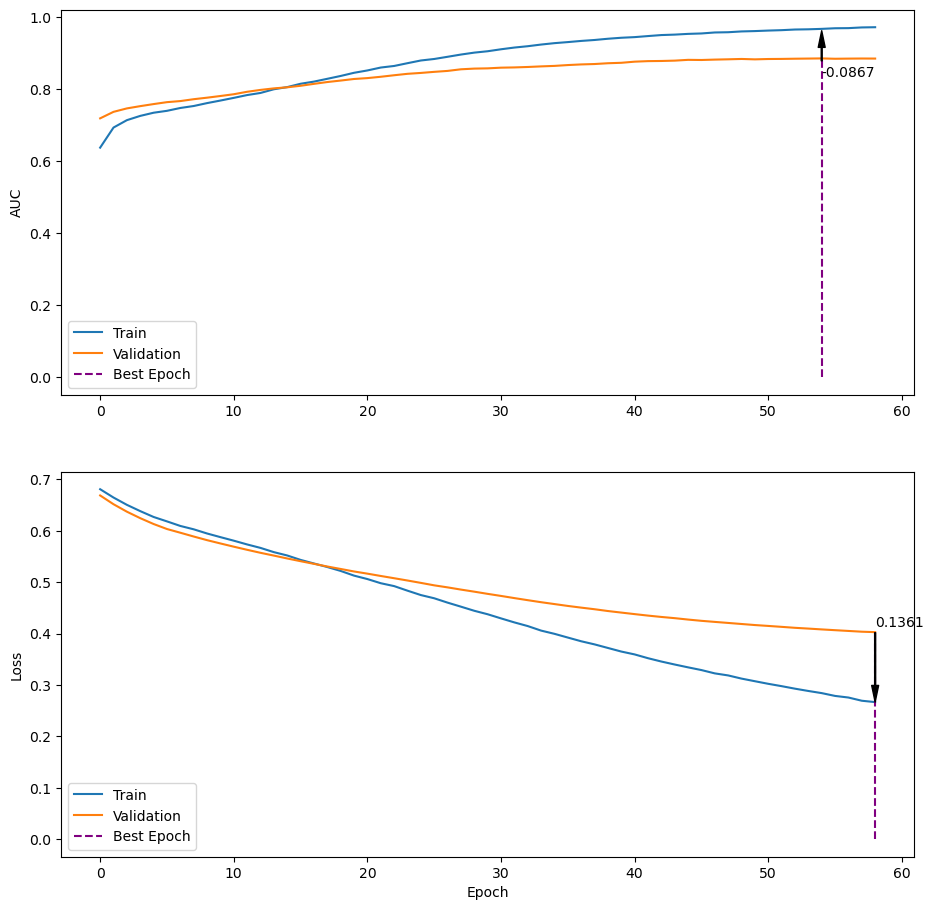

In [34]:
plot_history(model_results)

Above is a plot of the training and validation accuracy and loss. The model seems to be overfitting more as the epochs increase, and we can see the best epoch for loss is around 6, where the best epoch for accuracy is around 7. This indicates that the model may be overfitting and we should stop training the model at around 6 epochs or 7 epochs. However, the model may also be improved by changing the optimizer, learning rate, adding more layers or the amount of training data avaliable.

### Evaluate Model

In [35]:
model.load_weights('checkpoint.hd5')

model.evaluate([test_text, test_feats], y_test_n)

48/48 [==============================] - 2s 47ms/step - loss: 0.4407 - auc: 0.8647


[0.4406600296497345, 0.8646914958953857]

48/48 [==============================] - 2s 49ms/step


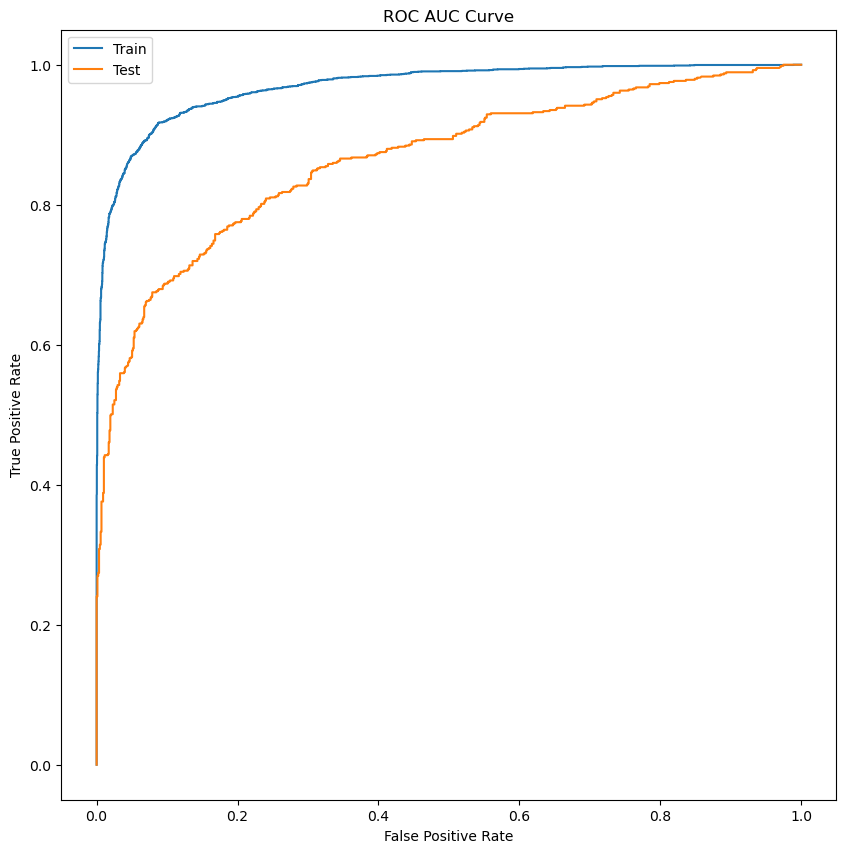

In [36]:
plot_roc([train_text, train_feats], [test_text, test_feats], y_train_n, y_test_n, model)

Above we see the results for our test data set. The model has an AUC of .865, which is not bad. However, from the ROC AUC plot above we can see that the model is still overfitting to the training data and is not generalizing to the test data as well as it could. This could be due to many factors, such as the amount or accuracy of training data, the amount of features, the model architecture, the learning rate, and the amount of epochs. However, the model is still able to predict wheather or not a tweet is about a real disaster with a decent accuracy.